Text(0.5, 1.0, 'Impact of data scale (SIFT1M)')

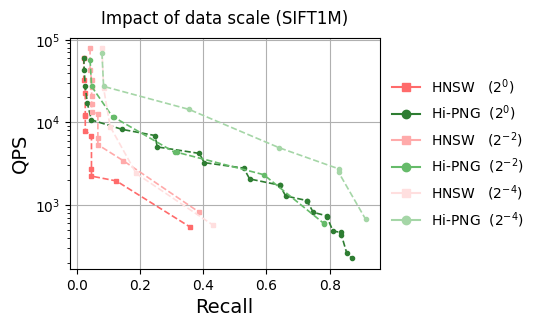

In [ ]:
dataset = 'text2image-10M-euclidean'

from function import pareto_frontier
import json, os
import matplotlib.pyplot as plt
import numpy as np

perf_output = "perf/scale"

plt.figure(figsize=(4, 3))

colors1 = ['#FF6B6B', '#FF8E8E', '#FFAAAA', '#FFC4C4', '#FFDFDF']  # Red gradient
colors2 = ['#2E7D32', '#43A047', '#66BB6A', '#81C784', '#A5D6A7']  # Green gradient (darker to lighter)

for i in range(0,5,2):
    perf1 = json.load(open(os.path.join(perf_output, f"{dataset}.{i}.HNSW.json")))
    perf2 = json.load(open(os.path.join(perf_output, f"{dataset}.{i}.Hi-PNG-HNSW.json")))
    perf1, perf2 = pareto_frontier(perf1, 0), pareto_frontier(perf2, 0)
    recall1, recall2 = [item["recall"] for item in perf1], [item["recall"] for item in perf2]
    qps1, qps2 = [item["qps"] for item in perf1], [item["qps"] for item in perf2]
    plt.plot(recall1, qps1, marker='s', color=colors1[i], linewidth=1.2, linestyle='dashed', markersize=3)
    plt.plot(recall2, qps2, marker='o', color=colors2[i], linewidth=1.2, linestyle='dashed', markersize=3)

    plt.yscale('log')
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('QPS', fontsize=14) 
    plt.grid(True)

legend_elements = []
for i in range(0,5,2):
    legend_elements.append(plt.Line2D([0], [0], marker='s', color=colors1[i], label=f'HNSW   ($2^{{{-i}}}$)'))
    legend_elements.append(plt.Line2D([0], [0], marker='o', color=colors2[i], label=f'Hi-PNG  ($2^{{{-i}}}$)'))
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.title("Impact of data scale (Text2Image)", pad=10)

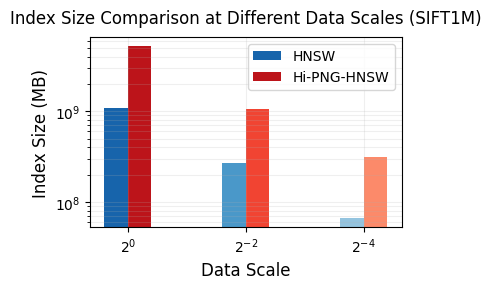

In [2]:
plt.figure(figsize=(4, 3))

index_sizes1 = []
index_sizes2 = []
scales = []

for i in range(0,5,2):
    perf1 = json.load(open(os.path.join(perf_output, f"{dataset}.{i}.HNSW.json")))
    perf2 = json.load(open(os.path.join(perf_output, f"{dataset}.{i}.Hi-PNG-HNSW.json")))
    index_sizes1.append(perf1[0]["index_size"])
    index_sizes2.append(perf2[0]["index_size"])
    scales.append(f"$2^{{{-i}}}$")

x = np.arange(len(scales))
width = 0.2

colors1 = plt.cm.Blues(np.linspace(0.8, 0.4, 3))
colors2 = plt.cm.Reds(np.linspace(0.8, 0.4, 3))

for i in range(0,5,2):
    plt.bar(x[i//2]-width/2, index_sizes1[i//2], width, label='HNSW' if i == 0 else "", color=colors1[i//2])
    plt.bar(x[i//2]+width/2, index_sizes2[i//2], width, label='Hi-PNG-HNSW' if i == 0 else "", color=colors2[i//2])

plt.xlabel('Data Scale', fontsize=12)
plt.ylabel('Index Size (MB)', fontsize=12)
plt.xticks(x, scales)
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()
plt.title("Index Size Comparison at Different Data Scales (SIFT1M)", pad=10)

plt.tight_layout()

In [ ]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

target_recalls = [0.90, 0.50]
data = {
    "Scale": [],
    "Method": [],
    "QPS(Recall@10=0.90)": [],
    "QPS(Recall@10=0.50)": [],
    "Index Size (GB)": [],
    "Data Size (GB)": [],
    "Build Time (s)": []
}

def get_closest_points(perf_data, target_recall):
    recalls = [p['recall'] for p in perf_data]
    qps = [p['qps'] for p in perf_data]
    sizes = [p['index_size'] / (1024**3) for p in perf_data]
    build_times = [p['build_time'] for p in perf_data]
    
    f_qps = interp1d(recalls, qps, kind='linear', fill_value='extrapolate')
    f_size = interp1d(recalls, sizes, kind='linear', fill_value='extrapolate')
    f_build_time = interp1d(recalls, build_times, kind='linear', fill_value='extrapolate')
    
    qps_value = float(f_qps(target_recall))
    return {
        'qps': '' if qps_value < 0 else round(qps_value, 2),
        'index_size': round(float(f_size(target_recall)), 2),
        'build_time': round(float(f_build_time(target_recall)), 2)
    }

data_sizes = [7.7, 1.93, 0.48]
for idx, i in enumerate(range(0,5,2)):
    scale = f"2^{{-{i}}}"

    perf1 = json.load(open(os.path.join(perf_output, f"{dataset}.{i}.HNSW.json")))
    perf1 = pareto_frontier(perf1, 0)
    point_90 = get_closest_points(perf1, 0.90)
    point_50 = get_closest_points(perf1, 0.50)
    data["Scale"].append(scale)
    data["Method"].append("HNSW")
    data["QPS(Recall@10=0.90)"].append(point_90["qps"])
    data["QPS(Recall@10=0.50)"].append(point_50["qps"])
    data["Index Size (GB)"].append(point_90["index_size"])
    data["Data Size (GB)"].append(data_sizes[idx])
    data["Build Time (s)"].append(point_90["build_time"])
    perf2 = json.load(open(os.path.join(perf_output, f"{dataset}.{i}.Hi-PNG-HNSW.json")))
    perf2 = pareto_frontier(perf2, 0)
    point_90 = get_closest_points(perf2, 0.90)
    point_50 = get_closest_points(perf2, 0.50)
    data["Scale"].append(scale)
    data["Method"].append("Hi-PNG-HNSW")
    data["QPS(Recall@10=0.90)"].append(point_90["qps"])
    data["QPS(Recall@10=0.50)"].append(point_50["qps"])
    data["Index Size (GB)"].append(point_90["index_size"])
    data["Data Size (GB)"].append(data_sizes[idx])
    data["Build Time (s)"].append(point_90["build_time"])
df = pd.DataFrame(data)
markdown_table = df.to_markdown(index=False, tablefmt="github", floatfmt=".2f")

from IPython.display import Markdown
Markdown(markdown_table)